In [1]:
%matplotlib inline

import theano
import theano.tensor as tt

import numpy as np
import matplotlib.pyplot as plt

from theano_ops.celerite.factor import FactorOp
from theano_ops.celerite.solve import SolveOp
from theano_ops.celerite import terms
from theano_ops.celerite.celerite import log_likelihood

In [2]:
S0 = tt.dscalar()
w0 = tt.dscalar()
Q = tt.dscalar()
kernel = terms.OverdampedSHOTerm(S0=S0, w0=w0, Q=Q)

In [3]:
omega = tt.dvector()
f = theano.function([S0, w0, Q, omega], kernel.psd(omega), on_unused_input="ignore")

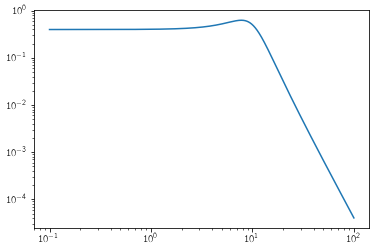

In [5]:
w = np.linspace(0.1, 100.0, 5000)
plt.loglog(w, f(0.5, 10.0, 1.123, w))

In [6]:
N = 100
diag_ = np.random.rand(N)
x = np.sort(np.random.uniform(0, 10, N))
y = np.sin(x)

In [7]:
f(0.5, 10.0, 1.123, x, diag_)

array([[ 6.43240667e+00,  5.52854340e+00,  3.59898535e+00, ...,
        -6.79954417e-20,  4.47922050e-19,  5.64698168e-19],
       [ 5.52854340e+00,  6.17448239e+00,  4.15006109e+00, ...,
         8.34920983e-19,  3.57934565e-19,  5.64441887e-19],
       [ 3.59898535e+00,  4.15006109e+00,  6.49486752e+00, ...,
         6.38599729e-18, -4.28332815e-19,  2.64581550e-19],
       ...,
       [-6.79954417e-20,  8.34920983e-19,  6.38599729e-18, ...,
         6.07301226e+00, -9.90819708e-01, -5.53556517e-01],
       [ 4.47922050e-19,  3.57934565e-19, -4.28332815e-19, ...,
        -9.90819708e-01,  5.88233531e+00,  4.56003067e+00],
       [ 5.64698168e-19,  5.64441887e-19,  2.64581550e-19, ...,
        -5.53556517e-01,  4.56003067e+00,  6.53471716e+00]])

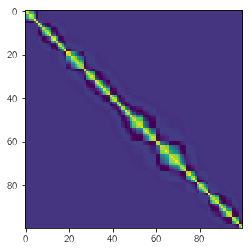

In [9]:
plt.imshow(f(0.5, 10.0, 1.123, x, diag_))

In [5]:
diag_ = tt.dvector()
x_ = tt.dvector()
y_ = tt.dvector()
loglike, z, d, W, a, U, V, P = log_likelihood(kernel, diag, x, y)
coeffs = kernel.get_coefficients()
coeffs

(Alloc.0, Alloc.0, Reshape{1}.0, Reshape{1}.0, Reshape{1}.0, Reshape{1}.0)

In [10]:
f = theano.function([S0, w0, Q], coeffs[3], on_unused_input="ignore")
g = theano.function([S0, w0, Q], theano.grad(loglike, [S0, w0, Q]), on_unused_input="ignore")

In [11]:
g(0.5, 10.0, 1.123)

[array(-297.88030836), array(-55.39903664), array(-37.4005025)]

In [5]:
a = tt.dvector()
U = tt.dmatrix()
V = tt.dmatrix()
P = tt.dmatrix()
Y = tt.dmatrix()

factor_op = FactorOp(J=2)
d, W, _ = factor_op(a, U, V, P)
solve_op = SolveOp(J=2, n_rhs=1)
Z, F, G = solve_op(U, P, d, W, Y)

f = theano.function([a, U, V, P, Y], Z)
g = theano.function([a, U, V, P, Y], theano.grad(tt.sum(Z), [a, U, V, P, Y]))

In [6]:
N = 10000
diag = np.random.rand(N)
x = np.sort(np.random.uniform(0, 10, N))
y = np.sin(x)[:, None]

a_real = np.random.rand(2)
c_real = np.random.rand(2)
a_comp = np.array([])
b_comp = np.array([])
c_comp = np.array([])
d_comp = np.array([])

a_ = diag + np.sum(a_real) + np.sum(a_comp)

U_ = np.concatenate((
    a_real[None, :] + np.zeros_like(x)[:, None],
    a_comp[None, :] * np.cos(d_comp[None, :] * x[:, None])
    + b_comp[None, :] * np.sin(d_comp[None, :] * x[:, None]),
    a_comp[None, :] * np.sin(d_comp[None, :] * x[:, None])
    - b_comp[None, :] * np.cos(d_comp[None, :] * x[:, None]),
), axis=1)

V_ = np.concatenate((
    np.zeros_like(a_real)[None, :] + np.ones_like(x)[:, None],
    np.cos(d_comp[None, :] * x[:, None]),
    np.sin(d_comp[None, :] * x[:, None]),
), axis=1)

dx = x[1:] - x[:-1]
P_ = np.concatenate((
    np.exp(-c_real[None, :] * dx[:, None]),
    np.exp(-c_comp[None, :] * dx[:, None]),
    np.exp(-c_comp[None, :] * dx[:, None]),
), axis=1)

%timeit f(a_, U_, V_, P_, y)
%timeit g(a_, U_, V_, P_, y)

1000 loops, best of 3: 387 µs per loop
1000 loops, best of 3: 950 µs per loop


In [12]:
tt.cast(tt.zeros(5), theano.config.floatX)

Alloc.0

In [20]:
x = tt.dscalar()

x[None]

InplaceDimShuffle{x}.0

In [24]:
f = theano.function([x], tt.reshape(x, (x.size, )))

In [25]:
f(0.1)

array([0.1])